In [1]:
import os, sys, warnings, time, memory_profiler
import numpy as np, matplotlib.pyplot as plt
from sequentia import *
from tqdm.auto import tqdm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, Flatten

# Silence TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Import utility functions and classes
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from utils import *
from nn import NNClassifier

# Filter warnings
warnings.filterwarnings('ignore')

# ggplot style
plt.style.use('ggplot')

# Set seed for reproducible randomness
seed = 0
np.random.seed(seed)
rng = np.random.RandomState(seed=seed)

In [2]:
gestures_map = {
    'nd': 'nod',
    'mnd': 'multiple nods',
    'fu': 'face-up',
    'fd': 'face-down',
    'sh': 'shake',
    't': 'turn',
    'ti': 'tilt'
}

gestures = list(gestures_map.keys())

In [3]:
fields = ['Rx', 'Ry', 'Rz']

In [4]:
# Containers to store classifiers and results
clfs, results = {}, {'hmm': {}, 'knn': {}, 'ffnn': {}, 'lstm': {}}

In [5]:
# Load the MoCap dataset
loader = MoCapLoader(normalized=False)
X, y = loader.load(fields)

## Dataset splits

Create a stratified 65-20-15 training, validation and test set split.

In [6]:
# Create a stratified training, validation and test set split (65-20-15)
X_train, X_val, X_test, y_train, y_val, y_test = data_split(X, y, (65, 20, 15), random_state=rng, stratify=True)

Training set size: 841
Validation set size: 259
Test set size: 195


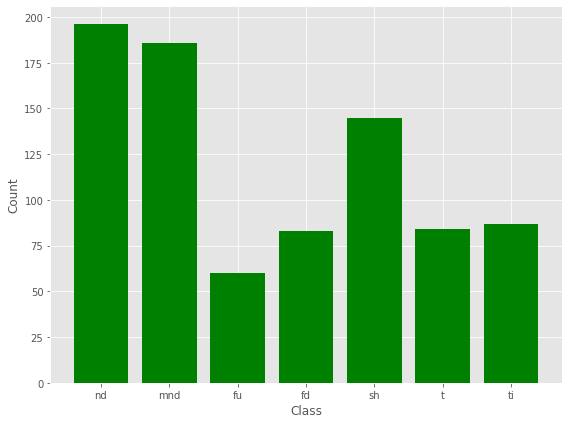

In [7]:
# MoCap dataset class counts (training set)
show_class_counts(y_train, gestures, title=None)

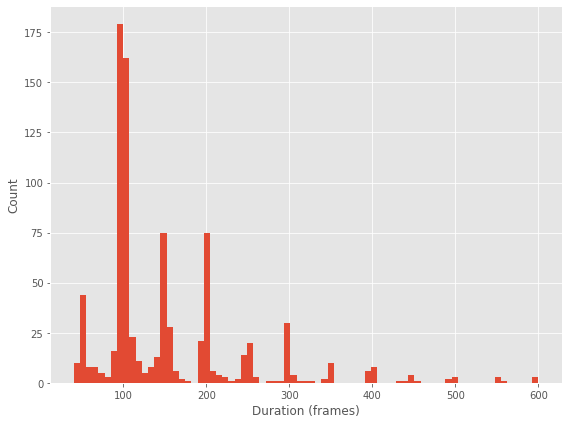

In [8]:
# Histogram of MoCap dataset gesture durations (training set)
show_durations(X_train, bins=75, title=None)

## Preprocessing

In [9]:
# Create a preprocessing pipeline
pre = Preprocess([
    Filter(window_size=10, method='median'),
    BinDownsample(bin_size=50, method='decimate'),
    Center()
])
pre.summary()

             Preprocessing summary:            
1. Filter
   Median filtering with window-size 10
-----------------------------------------------
2. BinDownsample
   Decimation bin-downsampling with bin-size 50
-----------------------------------------------
3. Center
   Centering around mean (zero mean)


In [10]:
# Function for visualizing gesture signals
def plot_gesture(gesture, label, figsize=(7, 5), same_scale=True):
    labels = ['$\\varphi^{(t)}_x$', '$\\varphi^{(t)}_y$', '$\\varphi^{(t)}_z$']
    colors = ['blue', 'red', 'green']
    fig, axs = plt.subplots(3, 1, sharex=True, figsize=figsize)
    
    for i, ax in enumerate(axs.flat):
        ax.plot(gesture[:, i], color=colors[i])
        ax.set_ylabel(labels[i], rotation=0, labelpad=7, fontsize=14)
        if same_scale:
            pad = 0.05
            ax.set_ylim(gesture.min()-pad, gesture.max()+pad)
    ax.set_xlabel('Duration (frames)')
        
    fig.tight_layout()
#     plt.savefig('plots/example-rotation-signal.pdf')
    plt.show()

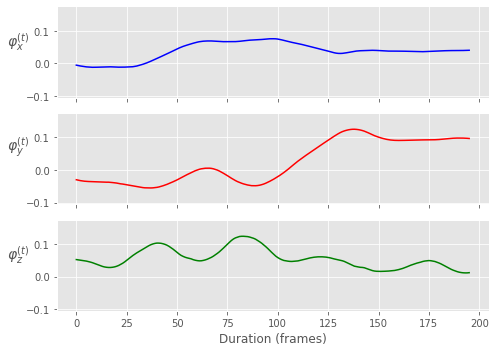

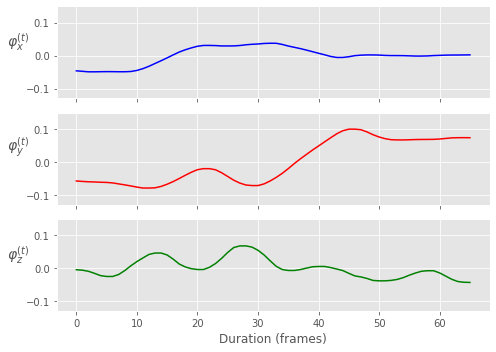

In [11]:
# Pick an example signal for visualization
x_sample, y_sample = X_train[1], y_train[1]
plot_gesture(x_sample, y_sample)
plot_gesture(pre.transform(x_sample), y_sample)

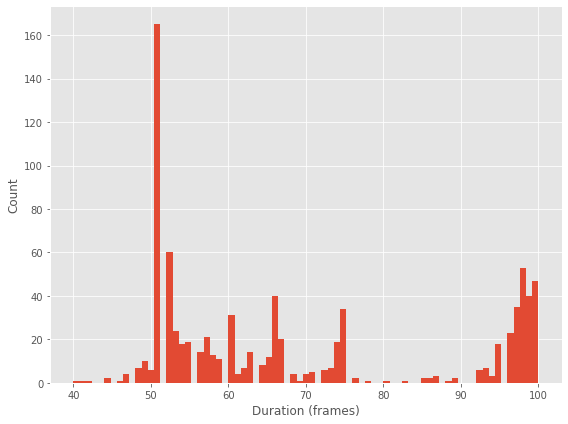

In [12]:
# Transform training data and plot histogram of MoCap dataset gesture durations (training set)
Xp_train = pre.fit_transform(X_train, verbose=True)
show_durations(Xp_train, bins=75, title=None)

In [13]:
# Apply the preprocessing pipeline to the other dataset splits
Xp_val, Xp_test = pre.transform(X_val, verbose=True), pre.transform(X_test, verbose=True)

## DTWKNN classifier

### Fitting the model

### Evaluating the model

## Hidden Markov Model classifier

One gesture model $\lambda_i=(A_i,B_i,\pi_i)$ is initialized and trained for each of the gestures: `nd`, `mnd`, `sh`, `fd`, `t`, `ti`, `fu`.

### Training the model

### Evaluating the model

## Feedforward Neural Network classifier

### Fitting the model

### Evaluating the model

## LSTM classifier

### Fitting the model

### Evaluating the model

# Hyper-parameter searches

## HMM

## DTWKNN

### Radius parameter

### Neighborhood parameter ($k$)

## FFNN

## LSTM

# Test results

## DTWKNN

## HMM

## FFNN

In [14]:
epochs = None

for repeat in range(5):
    seed = repeat
    np.random.seed(seed)
    rng = np.random.RandomState(seed=seed)
    
    X_train, X_val, X_test, y_train, y_val, y_test = data_split(X, y, (65, 20, 15), random_state=rng, stratify=True)
    Xp_train = pre.fit_transform(X_train, verbose=True)
    Xp_val, Xp_test = pre.transform(X_val, verbose=True), pre.transform(X_test, verbose=True)

    clf = None
    running_stats = {'fit': {}, 'predict': {}}

    def fit():
        e = 500 if epochs is None else epochs
        clf = NNClassifier(epochs=e, batch_size=128, optimizer=Adam(learning_rate=0.002), classes=gestures)

        arch = [
            Flatten(),
            Dense(300, activation='relu'), 
            Dropout(0.5),
            Dense(300, activation='relu'), 
            Dropout(0.5),
            Dense(len(gestures), activation='softmax')
        ]

        if epochs is None:
            hist = clf.fit(arch, Xp_train, y_train, validation_data=(Xp_val, y_val), return_history=True, verbose=2, patience=40)
        else:
            hist = clf.fit(arch, Xp_train, y_train, validation_data=(Xp_val, y_val), return_history=True, verbose=2, early_stop=False)
        return clf, hist

    t0 = time.time()
    mem, out = memory_profiler.memory_usage(fit, retval=True)
    clf, hist = out
    running_stats['fit']['memory'] = max(mem)
    running_stats['fit']['time'] = time.time() - t0
    
    if epochs is None:
        epochs = len(hist.history['loss'])

    def evaluate():
        return clf.evaluate(Xp_test, y_test)

    t0 = time.time()
    mem, res = memory_profiler.memory_usage(evaluate, retval=True)
    running_stats['predict']['memory'] = max(mem)
    running_stats['predict']['time'] = time.time() - t0
    results['ffnn']['test'] = res

    # Write the results
    write_network_results('ffnn', results, hist, running_stats, 'final', 'test', number=repeat, save_history=True, save_cm=True)

Training set size: 841
Validation set size: 259
Test set size: 195



Train on 841 samples, validate on 259 samples
Epoch 1/500
841/841 [==============================] - 2s 3ms/sample - loss: 1.9199 - accuracy: 0.1962 - val_loss: 1.8634 - val_accuracy: 0.2432
Epoch 2/500
841/841 [==============================] - 0s 75us/sample - loss: 1.8373 - accuracy: 0.2652 - val_loss: 1.7847 - val_accuracy: 0.2548
Epoch 3/500
841/841 [==============================] - 0s 102us/sample - loss: 1.7635 - accuracy: 0.2723 - val_loss: 1.6928 - val_accuracy: 0.2934
Epoch 4/500
841/841 [==============================] - 0s 84us/sample - loss: 1.6806 - accuracy: 0.3543 - val_loss: 1.6220 - val_accuracy: 0.3861
Epoch 5/500
841/841 [==============================] - 0s 70us/sample - loss: 1.6157 - accuracy: 0.4090 - val_loss: 1.5600 - val_accuracy: 0.4093
Epoch 6/500
841/841 [==============================] - 0s 65us/sample - loss: 1.5648 - accuracy: 0.3888 - val_loss: 1.5357 - val_accuracy: 0.3784
Epoch 7/500
841/841 [==============================] - 0s 88us/sample - loss:


Train on 841 samples, validate on 259 samples
Epoch 1/114
841/841 [==============================] - 1s 2ms/sample - loss: 1.9244 - accuracy: 0.2081 - val_loss: 1.8674 - val_accuracy: 0.2317
Epoch 2/114
841/841 [==============================] - 0s 96us/sample - loss: 1.8282 - accuracy: 0.2830 - val_loss: 1.7978 - val_accuracy: 0.2625
Epoch 3/114
841/841 [==============================] - 0s 90us/sample - loss: 1.7342 - accuracy: 0.3234 - val_loss: 1.7259 - val_accuracy: 0.3243
Epoch 4/114
841/841 [==============================] - 0s 108us/sample - loss: 1.6409 - accuracy: 0.3472 - val_loss: 1.6680 - val_accuracy: 0.4015
Epoch 5/114
841/841 [==============================] - 0s 103us/sample - loss: 1.5886 - accuracy: 0.3603 - val_loss: 1.6327 - val_accuracy: 0.3822
Epoch 6/114
841/841 [==============================] - 0s 73us/sample - loss: 1.5240 - accuracy: 0.3900 - val_loss: 1.6065 - val_accuracy: 0.3591
Epoch 7/114
841/841 [==============================] - 0s 108us/sample - los


Train on 841 samples, validate on 259 samples
Epoch 1/114
841/841 [==============================] - 1s 2ms/sample - loss: 1.9179 - accuracy: 0.2033 - val_loss: 1.8605 - val_accuracy: 0.2394
Epoch 2/114
841/841 [==============================] - 0s 90us/sample - loss: 1.8126 - accuracy: 0.2794 - val_loss: 1.7928 - val_accuracy: 0.2819
Epoch 3/114
841/841 [==============================] - 0s 89us/sample - loss: 1.7326 - accuracy: 0.3365 - val_loss: 1.7180 - val_accuracy: 0.3166
Epoch 4/114
841/841 [==============================] - 0s 73us/sample - loss: 1.6492 - accuracy: 0.3650 - val_loss: 1.6548 - val_accuracy: 0.3475
Epoch 5/114
841/841 [==============================] - 0s 102us/sample - loss: 1.5787 - accuracy: 0.4043 - val_loss: 1.6143 - val_accuracy: 0.3552
Epoch 6/114
841/841 [==============================] - 0s 66us/sample - loss: 1.5306 - accuracy: 0.4126 - val_loss: 1.5906 - val_accuracy: 0.3552
Epoch 7/114
841/841 [==============================] - 0s 92us/sample - loss:


Train on 841 samples, validate on 259 samples
Epoch 1/114
841/841 [==============================] - 1s 2ms/sample - loss: 1.9214 - accuracy: 0.2152 - val_loss: 1.8584 - val_accuracy: 0.2510
Epoch 2/114
841/841 [==============================] - 0s 92us/sample - loss: 1.8313 - accuracy: 0.2473 - val_loss: 1.7775 - val_accuracy: 0.2741
Epoch 3/114
841/841 [==============================] - 0s 123us/sample - loss: 1.7490 - accuracy: 0.2723 - val_loss: 1.6875 - val_accuracy: 0.3707
Epoch 4/114
841/841 [==============================] - 0s 123us/sample - loss: 1.6674 - accuracy: 0.3472 - val_loss: 1.6120 - val_accuracy: 0.4093
Epoch 5/114
841/841 [==============================] - 0s 108us/sample - loss: 1.5968 - accuracy: 0.3817 - val_loss: 1.5686 - val_accuracy: 0.4015
Epoch 6/114
841/841 [==============================] - 0s 111us/sample - loss: 1.5247 - accuracy: 0.4043 - val_loss: 1.5617 - val_accuracy: 0.3861
Epoch 7/114
841/841 [==============================] - 0s 83us/sample - lo


Train on 841 samples, validate on 259 samples
Epoch 1/114
841/841 [==============================] - 1s 1ms/sample - loss: 1.9159 - accuracy: 0.2140 - val_loss: 1.8722 - val_accuracy: 0.2432
Epoch 2/114
841/841 [==============================] - 0s 94us/sample - loss: 1.8140 - accuracy: 0.3103 - val_loss: 1.8167 - val_accuracy: 0.2471
Epoch 3/114
841/841 [==============================] - 0s 79us/sample - loss: 1.7229 - accuracy: 0.3282 - val_loss: 1.7673 - val_accuracy: 0.2896
Epoch 4/114
841/841 [==============================] - 0s 89us/sample - loss: 1.6569 - accuracy: 0.3639 - val_loss: 1.7275 - val_accuracy: 0.3127
Epoch 5/114
841/841 [==============================] - 0s 91us/sample - loss: 1.5630 - accuracy: 0.4138 - val_loss: 1.7082 - val_accuracy: 0.3127
Epoch 6/114
841/841 [==============================] - 0s 82us/sample - loss: 1.4819 - accuracy: 0.4174 - val_loss: 1.7037 - val_accuracy: 0.3127
Epoch 7/114
841/841 [==============================] - 0s 105us/sample - loss: